# This file is a mess

While this file contains the most up-to-date code for modeling a particle in 3 dimensions, there are probably quite a few bugs in this code. What would be better would be to return to the 1D model (which seems to behave optimally), and then build it carefully up one state at a time until the full 3D state was realized without errors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

inv = np.linalg.inv

In [2]:
!ls ios

IneritalDataAcquisition
bias-rectification-old.csv
bias-rectification.csv
bike-around-block-with-acceleration-facing-in.csv
bike-around-block-with-acceleration.csv
bike-around-block.csv
bike-around-parking-lot.csv
my_iOS_device 200216 20_47_14.csv
rotation-along-principle-axes.csv
rotation-along-principle-axes_old.csv
rotation-through-g-field.csv
shake-north-and-east.csv
shake-with-gps-old.csv
shake-with-gps.csv
sideways-shake.csv
sit-on-couch.csv
slow-rotation.csv
train-ride.csv
walk-around-block.csv
walk-around-mva.csv
z-bias-balance.csv


In [3]:
filename = 'ios/rotation-through-g-field.csv'
fields = pd.read_csv('ios/shake-with-gps.csv').columns
filename = 'ios/walk-around-block.csv'
filename = 'ios/bike-around-block.csv'
#filename = 'ios/bike-around-block-with-acceleration.csv'
#filename = 'ios/bike-around-block-with-acceleration-facing-in.csv'
#filename = 'ios/bike-around-parking-lot.csv'
#filename = 'ios/sideways-shake.csv'
#filename = 'ios/z-bias-balance.csv'
(t, _, _,location_timestamp,
latitude, longitude, altitude,
 _, _, vertical_accuracy, horizontal_accuracy, _, 
at, ax, ay, az,
gt, gx, gy, gz,
_, magx, magy, magz,
_, _, alt, _,
) = pd.read_csv(filename)[fields].values.T[:,::5] #[:,int(0e2):int(840e2):30]

In [4]:
ax

array([0.0059967041015625, 0.005645751953125, 0.006317138671875, ...,
       0.0403900146484375, 0.034454345703125, 0.0484619140625],
      dtype=object)

In [5]:
t = pd.to_datetime(t)
t[-1] - t[0]

Timedelta('0 days 00:05:16.267000')

In [7]:
np.median(gz)

-0.001288171042688191

In [8]:
azb = -.0085
azb = .033
axb = -.001
ayb = -.002

gzb = -0.0055
gyb = 0# -0.0097045
gxb = 0#-0.012817940597675125

In [9]:
 np.mean((az)) - azb

-1.0417822488572996

In [10]:
dt = ((t[-1] - t[0]) / (len(t) - 1)).value / 1e9

In [11]:
def R_(yaw, pitch, roll):
    """http://planning.cs.uiuc.edu/node102.html"""
    """Performs first roll, then pitch, then yaw"""
    """a : alpha, yaw"""
    """b: beta, pitch"""
    """r: gamma, roll"""
    ca = np.cos(yaw)
    cb = np.cos(pitch)
    cg = np.cos(roll)
    sa = np.sin(yaw)
    sb = np.sin(pitch)
    sg = np.sin(roll)
    
    
    yR = np.array([
        [ca, sa, 0],
        [-sa, ca, 0],
        [0, 0, 1]
    ])
    
    pR = np.array([
        [1, 0, 0],
        [0, cb, sb],
        [0, -sb, cb]
    ])
    
    rR = np.array([
        [cg, 0, -sg],
        [0, 1, 0],
        [sg, 0, cg]
    ])
    
    #return rR @ pR @ yR
    return np.array([
        [ca*cg - sa*sb*sg, cg*sa + ca*sb*sg, -cb*sg],
        [-cb*sa, ca*cb, sb],
        [cg*sa*sb + ca*sg, -ca*cg*sb + sa*sg, cb*cg]
    ])

def get_yaw_pitch_roll_from_R(R):
    """https://math.stackexchange.com/a/2802520"""
    yaw = np.angle(-1j*R[1,0] + R[1,1])
    pitch = np.arcsin(R[1,2])
    roll = np.arctan(-R[0,2]/R[2,2])
    
    return yaw, pitch, roll

def h(mu):
    pitch, roll = mu
    return R_(0, pitch, roll) @ np.array([0, 0, -1])

In [12]:
get_yaw_pitch_roll_from_R(R_(-1, -.2, -.5))

(-1.0, -0.2, -0.5)

In [13]:
def new_GPS(time_index):
    """Return the GPS coordinates if they exist at this timestamp. Otherwise, return none"""
    lat, lng, alt = (
        np.stack([latitude, longitude, altitude]).T[time_index]
    )
    earth_radius = 6.3781e6 # meter
    dy = np.radians(lat - latitude[0]) *  earth_radius
    dx = np.radians(lng - longitude[0]) * earth_radius * np.cos(np.radians(latitude[0]))
    if time_index == 0:
        return dx, dy, alt
    elif location_timestamp[time_index] == location_timestamp[time_index-1]:
        return None
    else:
        return dx, dy, alt

# Here is the meat and potatos. 

This has the relaxed Q parameters, which pretend that the accelerometer is more noisy than it actually is in an attempt to get the GNSS to update to the real position.

In [46]:
Q_acc = 1
Q_ang = .2

number_of_timesteps = len(t)
number_of_states = 9

inertial_accels = np.empty((number_of_timesteps, 3)) * np.nan

Q = np.array([
    [(Q_ang*dt)**2*50, 0, 0,  0,0,0, 0,0,0],  
    [0, (Q_ang*dt)**2, 0,  0,0,0, 0,0,0],   
    [0, 0, (Q_ang*dt)**2,  0,0,0, 0,0,0],
    
    [0,0,0,  0,0,0, 0,0,0],
    [0,0,0,  0,0,0, 0,0,0],
    [0,0,0,  0,0,0, 0,0,0],
    
    [0,0,0,  0,0,0, (Q_acc*dt)**2,0,0],
    [0,0,0,  0,0,0, 0,(Q_acc*dt)**2,0],
    [0,0,0,  0,0,0, 0,0,(Q_acc*dt)**2],
])    

kalman_states = np.empty((number_of_timesteps, number_of_states)) * np.nan
kalman_errors = np.empty((number_of_timesteps, number_of_states)) * np.nan

I = np.identity(number_of_states)
last_gps_time_index = 0

# initialize state
# mu :
# [yaw, pitch, roll, rx, ry, rz, vx, vy, vz]
mu = np.array([-.2 - np.pi*1, 0, 0, 0, 0, 0, 0,0,0])
P = np.array([
    [np.pi*2, 0, 0,  0, 0, 0,  0, 0, 0],
    [0, np.pi/40, 0,  0, 0, 0,  0, 0, 0],
    [0, 0, np.pi/40,  0, 0, 0,  0, 0, 0],    
    [0, 0, 0,  100, 0, 0,  0, 0, 0],    
    [0, 0, 0,  0, 100, 0,  0, 0, 0],
    [0, 0, 0,  0, 0, 100,  0, 0, 0],
    [0, 0, 0,  0, 0, 0,  .1, 0, 0],
    [0, 0, 0,  0, 0, 0,  0, .1, 0],
    [0, 0, 0,  0, 0, 0,  0, 0, .1],
])**2

g = 9.81

for time_index in range(number_of_timesteps):
    # Kalman step


    ax_, ay_, az_ = np.stack([ax, ay, az]).T[time_index, :]
    
    def f(mu, u):
        gx, gy, gz, ax_, ay_, az_ = u
        dyaw = (gz - gzb) * dt 
        dpitch = gx * dt 
        droll = gy * dt 
        
        yaw, pitch, roll, rx, ry, rz, vx, vy, vz = mu
        #total_R = R_(dyaw, dpitch, droll) @ R_(yaw, pitch, roll) 
        #yaw, pitch, roll = get_yaw_pitch_roll_from_R(total_R)
        yaw += dyaw * dt
        
        ca = np.cos(yaw)
        sa = np.sin(yaw)
        #average_R =  R_(yaw, pitch, roll)        
        average_R = np.array([
            [ca, -sa, 0],
            [sa, ca, 0],
            [0, 0, 1]
        ])
        
        accels = (
            average_R.T @
            np.array([ax_ - axb, ay_ - ayb, az_ - azb])
            + np.array([0, 0, 1]))
        #inertial_accels[time_index, :] = accels
        
        aX, aY, aZ = accels * g 
        aZ = 0
        
        rx += aX * dt ** 2 / 2 + vx * dt
        ry += aY * dt ** 2 / 2 + vy * dt
        rz += aZ * dt ** 2 / 2 + vz * dt
        
        vx += aX * dt / 2
        vy += aY * dt / 2
        vz += aZ * dt / 2
        mu = np.array([yaw, pitch, roll,
                       rx, ry, rz,
                       vx, vy, vz
                      ])
        
        return mu
    
    def h(mu):
        yaw, pitch, roll = mu[0:3]
        return R_(0, pitch, roll) @ np.array([0, 0, -1]) - np.array([axb, ayb, azb])

    yaw, pitch, roll = mu[0:3]
    ca = np.cos(yaw)
    sa = np.sin(yaw)
    cb = np.cos(pitch)
    sb = np.sin(pitch)
    sg = np.sin(roll)
    cg = np.cos(roll)
    vx, vy, vz = mu[6:9]
    
    aX, aY, aZ = np.array([ax_, ay_, az_]) * g
    aX, aY, aZ = np.array([ax_, ay_, 0]) * g    
    
    daxda = ((-sa*cg-ca*sb*sg)*aX + (-cb*ca) * aY + (ca*sb*cg - sa*sg) * aZ)
    dayda = ((ca*cg-sa*sb*sg) *aX + (-sa*cb) * aY + (sa*sb*cg + ca*sg) * aZ)
    dazda = (0) 
    
    daxdb = -sa * cb*sg * aX + sb*sa * aY  +sa*cb*cg * aZ
    daydb =    ca*cb*sg * aX  -ca*sb * aY  -ca*cg*cb * aZ
    dazdb =       sb*sg * aX    + cb * aY     -sb*cg * aZ
    
    daxdg = (-ca*sg - sa*sb*cg) * aX * 0*aY +  (-sa*sb*sg+ca*cg) * aZ
    daydg =   (-sa*sg+ca*sb*cg) * aX + 0*aY + (ca*sb*sg + sa*cg) * aZ
    dazdg =            (-cb*cg) * aX + 0*aY              - cb*sg * aZ
    
    F = np.array([
        [1, 0, 0,  0, 0, 0,  0, 0, 0], #(-vx*sa-sgn*ca*vy), (sgn*vx*ca-sa*vy), 0],
        [0, 1, 0,  0, 0, 0,  0, 0, 0],
        [0, 0, 1,  0, 0, 0,  0, 0, 0],
        
        [daxda*dt**2/2, daxdb*dt**2/2, daxdg*dt**2/2,  1, 0, 0,  dt, 0, 0],
        [dayda*dt**2/2, daydb*dt**2/2, daydg*dt**2/2,  0, 1, 0,  0, dt, 0],
        [dazda*dt**2/2, dazdb*dt**2/2, dazdg*dt**2/2,  0, 0, 1,  0, 0, dt],
        
        [daxda*dt, daxdb*dt, daxdg*dt,  0, 0, 0,  1, 0, 0],
        [dayda*dt, daydb*dt, daydg*dt,  0, 0, 0,  0, 1, 0],
        [dazda*dt, dazdb*dt, dazdg*dt,  0, 0, 0,  0, 0, 1]
    ])
    
    z = np.array([ax_, ay_, az_])
    
    """Calculate pitch and roll from gravity vector"""
    pitch, roll = mu[1:3]        
    cb = np.cos(pitch)
    sb = np.sin(pitch)
    cg = np.cos(roll)
    sg = np.sin(roll)
    
    closeness = abs((ax_**2 + ay_**2 + az_**2)**.5 - 1) * .3
    R = np.identity(3) * closeness**2
    H = -(np.array([
        [0, sb*sg, -cb*cg,  0,0,0, 0,0,0],
        [0, cb, 0,          0,0,0, 0,0,0],
        [0, -sb*cg, -cb*sg, 0,0,0, 0,0,0]     
    ]))

    # Predict
    u = np.vstack([gx, gy, gz, ax, ay, az]).T[time_index]
    mu_model = f(mu, u)
    P = F @ P @ F.T + Q

    # Update IMU based on gravity vector

    y = z - h(mu) 
    K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
    mu = mu_model + K @ y
    P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
    y = z - H @ mu # post-fit residual

    # If new GPS is available, update based on GPS position
    try:
        #if time_index < len(t) / 2:
        #    raise TypeError
        z = np.array(new_GPS(time_index))
        if z.shape == tuple():
            raise TypeError
        z[2] = 0
        
#        dgpst = (t[last_gps_time_index] - t[time_index]).value/1e9
#        if dgpst <= 0:
#            dgpst = dt
        
        H_GPS = np.array([
            [0,0,0, 1,0,0, 0,0,0],
            [0,0,0, 0,1,0, 0,0,0],
            [0,0,0, 0,0,1, 0,0,0],
#            [0,0,0, 0,0,0, 1,0,0],
#            [0,0,0, 0,0,0, 0,1,0],
#            [0,0,0, 0,0,0, 0,0,1]
        ])
        d_horizontal = horizontal_accuracy[time_index]
        d_vertical = 0#vertical_accuracy[time_index]
        
#        dlo = longitude[time_index] - longitude[time_index-1]
#        dla = latitude[time_index] - latitude[time_index-1]
#        dal = altitude[time_index] - altitude[time_index-1]
        
#        earth_radius = 6.3781e6 # meter
#        dx = np.sin(np.radians(latitude[time_index])) * earth_radius * np.radians(dlo)
#        dy = earth_radius * np.radians(dla)
#        dz = dal
        
#        z = np.hstack([z, [dx/dgpst, dy/dgpst, dz/dgpst]])
        
#        Q_GPS_vel = 100
        R_GPS = np.array([
            [d_horizontal, 0,0,],#  0,0,0],
            [0,d_horizontal, 0,],#  0,0,0],
            [0, 0,d_vertical,],# 0,0,0],
#            [0,0,0,  d_horizontal/dgpst*Q_GPS_vel, 0, 0],
#            [0,0,0,  0,d_horizontal/dgpst*Q_GPS_vel, 0],
#            [0,0,0,  0,0,d_vertical/dgpst*Q_GPS_vel] ,        
        ])**2
        y = z - H_GPS @ mu
        K = P @ H_GPS.T @ np.linalg.inv(R_GPS + H_GPS @ P @ H_GPS.T)
        mu = mu + K @ y
        P = (I - K @ H_GPS) @ P @ (I - K @ H_GPS).T + K @ R_GPS @ K.T        
        y = z - H_GPS @ mu
        
        if False and time_index > 0:
            dv = z - last_gps
            mu[6:9] = dv
        
        if False and time_index > 0:
            dlo = longitude[time_index] - longitude[time_index-1]
            dla = latitude[time_index] - latitude[time_index-1]
            new_yaw = np.arctan2(dla, dlo*np.cos(np.radians(latitude[time_index])))
            mu[0] = new_yaw
        #print('update', y)
        #print('K', K)
        #last_gps = z.copy()
        #last_gps_time_index = time_index
    except TypeError as e:
        pass
    
    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5

In [47]:
yaw, pitch, roll, rx, ry, rz ,vx, vy, vz = kalman_states.T
yawe, pitche, rolle, rxe, rye, rze, vxe, vye, vze = kalman_errors.T

In [48]:
gps_coords = np.array([
    (t[i], *new_GPS(i)) for i in range(len(t)) if new_GPS(i)
])

In [49]:
gps_t, dx, dy, dz = gps_coords.T

In [50]:
(gps_t[-1] - gps_t[0]) / (len(gps_t) - 1)

Timedelta('0 days 00:00:01.000053')

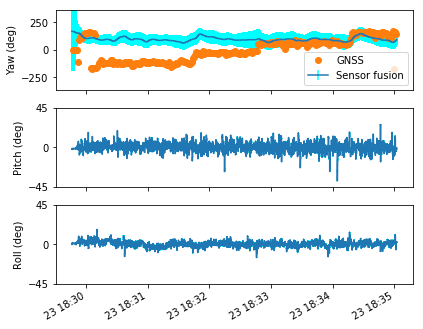

In [66]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(6,5))
ax1.errorbar(t, *np.degrees([yaw+np.pi*2, yawe]), ecolor='cyan', label='Sensor fusion')
ax2.errorbar(t, *np.degrees([pitch, pitche]), ecolor='cyan')
ax3.errorbar(t, *np.degrees([roll, rolle]), ecolor='cyan')

ax1.plot(gps_t[1:], np.degrees(yaw_gps), 'o', color='tab:orange', label='GNSS')

ax1.set_ylim([-360, 360])
ax2.set_yticks([-90, -45, 0, 45, 90])
ax2.set_ylim(-45, 45)
ax3.set_yticks([-90, -45, 0, 45, 90])
ax3.set_ylim(-45, 45)

ax1.legend(loc='lower right')

ax1.set_ylabel('Yaw (deg)')
ax2.set_ylabel('Pitch (deg)')
ax3.set_ylabel('Roll (deg)')
fig.tight_layout()
fig.autofmt_xdate()
plt.savefig('images/time-trace-of-bike-path.png', dpi=300)

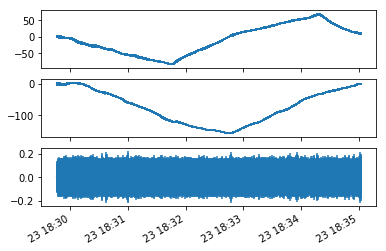

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
ax1.errorbar(t, rx, rxe)
ax2.errorbar(t, ry, rye)
ax3.errorbar(t, rz, rze)
fig.autofmt_xdate()

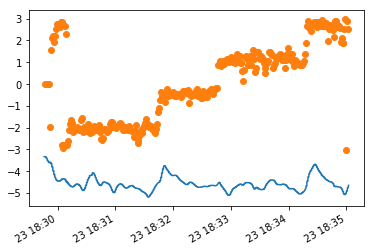

In [21]:
ddx = np.diff(dx).astype(float)
ddy = np.diff(dy).astype(float)
yaw_gps = np.arctan2(ddy, ddx)

plt.plot(t, yaw)
plt.plot(gps_t[1:], yaw_gps, 'o')
plt.gcf().autofmt_xdate()
plt.xlabel('East displacement (m)')
plt.ylabel('North displacement (m)')

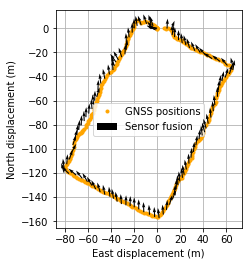

In [70]:
plt.figure(figsize=(4*5/6, 4))
interval = 60
#s = slice(0, int(len(t)/2), interval)
s = slice(0, -1, interval)
dirx = np.cos(yaw[s])
diry = np.sin(yaw[s])

plt.plot(dx, dy ,'.', color='orange', label='GNSS positions')

#plt.plot(rx[::interval], ry[::interval], 'o')
q = plt.quiver(rx[s], ry[s], dirx, diry, label='Sensor fusion', zorder=10)
plt.grid()
plt.legend(loc='best')
plt.xticks((-80, -60, -40, -20, 0, 20, 40, 60))
plt.yticks((0, -20, -40, -60, -80, -100, -120, -140, -160))
plt.xlabel('East displacement (m)')
plt.ylabel('North displacement (m)')
plt.savefig('images/walk-around-block.png', dpi=300, bbox_inches='tight')

In [23]:
plt.plot(rx[s], ry[s])
plt.plot(dx, dy, 'o')


NameError: name 's' is not defined

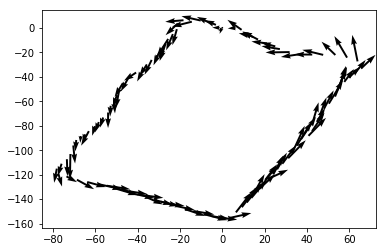

In [3196]:
interval = 50
dirx = np.cos(yaw[s])
diry = np.sin(yaw[s])
#plt.plot(rx[::interval], ry[::interval], 'o')
plt.quiver(rx[s], ry[s], vx[s], vy[s])


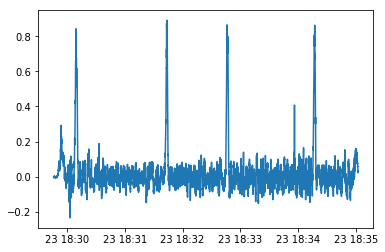

In [3120]:
plt.plot(t, gz)

In [3121]:
np.mean(gy)

0.0063774373414954766

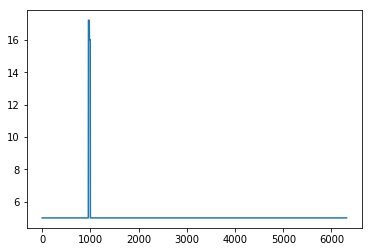

In [3122]:
plt.plot(horizontal_accuracy)

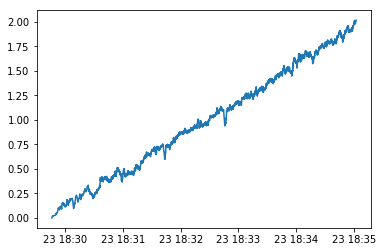

In [3123]:
gyb = 0
heading = np.cumsum(gy - gyb)*dt
plt.plot(t, heading)

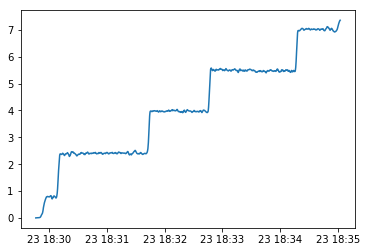

In [3124]:
heading = np.cumsum(gz - gzb)*dt
plt.plot(t, heading)

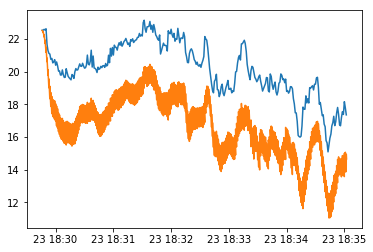

In [3125]:
plt.plot(gps_t, dz)
plt.plot(t, rz)

# With real Qs (not relaxed like in before)

In [72]:
Q_acc = 60e-6*9.8 * 100**.5 * dt
Q_ang = np.radians(8e-3 * 100**.5) * dt

number_of_timesteps = len(t)
number_of_states = 9

inertial_accels = np.empty((number_of_timesteps, 3)) * np.nan

Q = np.array([
    [(Q_ang*dt)**2*50, 0, 0,  0,0,0, 0,0,0],  
    [0, (Q_ang*dt)**2, 0,  0,0,0, 0,0,0],   
    [0, 0, (Q_ang*dt)**2,  0,0,0, 0,0,0],
    
    [0,0,0,  0,0,0, 0,0,0],
    [0,0,0,  0,0,0, 0,0,0],
    [0,0,0,  0,0,0, 0,0,0],
    
    [0,0,0,  0,0,0, (Q_acc*dt)**2,0,0],
    [0,0,0,  0,0,0, 0,(Q_acc*dt)**2,0],
    [0,0,0,  0,0,0, 0,0,(Q_acc*dt)**2],
])    

kalman_states = np.empty((number_of_timesteps, number_of_states)) * np.nan
kalman_errors = np.empty((number_of_timesteps, number_of_states)) * np.nan

I = np.identity(number_of_states)
last_gps_time_index = 0

# initialize state
# mu :
# [yaw, pitch, roll, rx, ry, rz, vx, vy, vz]
mu = np.array([-.2 - np.pi*1, 0, 0, 0, 0, 0, 0,0,0])
P = np.array([
    [np.pi*2, 0, 0,  0, 0, 0,  0, 0, 0],
    [0, np.pi/40, 0,  0, 0, 0,  0, 0, 0],
    [0, 0, np.pi/40,  0, 0, 0,  0, 0, 0],    
    [0, 0, 0,  100, 0, 0,  0, 0, 0],    
    [0, 0, 0,  0, 100, 0,  0, 0, 0],
    [0, 0, 0,  0, 0, 100,  0, 0, 0],
    [0, 0, 0,  0, 0, 0,  .1, 0, 0],
    [0, 0, 0,  0, 0, 0,  0, .1, 0],
    [0, 0, 0,  0, 0, 0,  0, 0, .1],
])**2

g = 9.81

for time_index in range(number_of_timesteps):
    # Kalman step


    ax_, ay_, az_ = np.stack([ax, ay, az]).T[time_index, :]
    
    def f(mu, u):
        gx, gy, gz, ax_, ay_, az_ = u
        dyaw = (gz - gzb) * dt 
        dpitch = gx * dt 
        droll = gy * dt 
        
        yaw, pitch, roll, rx, ry, rz, vx, vy, vz = mu
        #total_R = R_(dyaw, dpitch, droll) @ R_(yaw, pitch, roll) 
        #yaw, pitch, roll = get_yaw_pitch_roll_from_R(total_R)
        yaw += dyaw * dt
        
        ca = np.cos(yaw)
        sa = np.sin(yaw)
        #average_R =  R_(yaw, pitch, roll)        
        average_R = np.array([
            [ca, -sa, 0],
            [sa, ca, 0],
            [0, 0, 1]
        ])
        
        accels = (
            average_R.T @
            np.array([ax_ - axb, ay_ - ayb, az_ - azb])
            + np.array([0, 0, 1]))
        #inertial_accels[time_index, :] = accels
        
        aX, aY, aZ = accels * g 
        aZ = 0
        
        rx += aX * dt ** 2 / 2 + vx * dt
        ry += aY * dt ** 2 / 2 + vy * dt
        rz += aZ * dt ** 2 / 2 + vz * dt
        
        vx += aX * dt / 2
        vy += aY * dt / 2
        vz += aZ * dt / 2
        mu = np.array([yaw, pitch, roll,
                       rx, ry, rz,
                       vx, vy, vz
                      ])
        
        return mu
    
    def h(mu):
        yaw, pitch, roll = mu[0:3]
        return R_(0, pitch, roll) @ np.array([0, 0, -1]) - np.array([axb, ayb, azb])

    yaw, pitch, roll = mu[0:3]
    ca = np.cos(yaw)
    sa = np.sin(yaw)
    cb = np.cos(pitch)
    sb = np.sin(pitch)
    sg = np.sin(roll)
    cg = np.cos(roll)
    vx, vy, vz = mu[6:9]
    
    aX, aY, aZ = np.array([ax_, ay_, az_]) * g
    aX, aY, aZ = np.array([ax_, ay_, 0]) * g    
    
    daxda = ((-sa*cg-ca*sb*sg)*aX + (-cb*ca) * aY + (ca*sb*cg - sa*sg) * aZ)
    dayda = ((ca*cg-sa*sb*sg) *aX + (-sa*cb) * aY + (sa*sb*cg + ca*sg) * aZ)
    dazda = (0) 
    
    daxdb = -sa * cb*sg * aX + sb*sa * aY  +sa*cb*cg * aZ
    daydb =    ca*cb*sg * aX  -ca*sb * aY  -ca*cg*cb * aZ
    dazdb =       sb*sg * aX    + cb * aY     -sb*cg * aZ
    
    daxdg = (-ca*sg - sa*sb*cg) * aX * 0*aY +  (-sa*sb*sg+ca*cg) * aZ
    daydg =   (-sa*sg+ca*sb*cg) * aX + 0*aY + (ca*sb*sg + sa*cg) * aZ
    dazdg =            (-cb*cg) * aX + 0*aY              - cb*sg * aZ
    
    F = np.array([
        [1, 0, 0,  0, 0, 0,  0, 0, 0], #(-vx*sa-sgn*ca*vy), (sgn*vx*ca-sa*vy), 0],
        [0, 1, 0,  0, 0, 0,  0, 0, 0],
        [0, 0, 1,  0, 0, 0,  0, 0, 0],
        
        [daxda*dt**2/2, daxdb*dt**2/2, daxdg*dt**2/2,  1, 0, 0,  dt, 0, 0],
        [dayda*dt**2/2, daydb*dt**2/2, daydg*dt**2/2,  0, 1, 0,  0, dt, 0],
        [dazda*dt**2/2, dazdb*dt**2/2, dazdg*dt**2/2,  0, 0, 1,  0, 0, dt],
        
        [daxda*dt, daxdb*dt, daxdg*dt,  0, 0, 0,  1, 0, 0],
        [dayda*dt, daydb*dt, daydg*dt,  0, 0, 0,  0, 1, 0],
        [dazda*dt, dazdb*dt, dazdg*dt,  0, 0, 0,  0, 0, 1]
    ])
    
    z = np.array([ax_, ay_, az_])
    
    """Calculate pitch and roll from gravity vector"""
    pitch, roll = mu[1:3]        
    cb = np.cos(pitch)
    sb = np.sin(pitch)
    cg = np.cos(roll)
    sg = np.sin(roll)
    
    closeness = abs((ax_**2 + ay_**2 + az_**2)**.5 - 1) * .3
    R = np.identity(3) * closeness**2
    H = -(np.array([
        [0, sb*sg, -cb*cg,  0,0,0, 0,0,0],
        [0, cb, 0,          0,0,0, 0,0,0],
        [0, -sb*cg, -cb*sg, 0,0,0, 0,0,0]     
    ]))

    # Predict
    u = np.vstack([gx, gy, gz, ax, ay, az]).T[time_index]
    mu_model = f(mu, u)
    P = F @ P @ F.T + Q

    # Update IMU based on gravity vector

    y = z - h(mu) 
    K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
    mu = mu_model + K @ y
    P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
    y = z - H @ mu # post-fit residual

    # If new GPS is available, update based on GPS position
    try:
        #if time_index < len(t) / 2:
        #    raise TypeError
        z = np.array(new_GPS(time_index))
        if z.shape == tuple():
            raise TypeError
        z[2] = 0
        
#        dgpst = (t[last_gps_time_index] - t[time_index]).value/1e9
#        if dgpst <= 0:
#            dgpst = dt
        
        H_GPS = np.array([
            [0,0,0, 1,0,0, 0,0,0],
            [0,0,0, 0,1,0, 0,0,0],
            [0,0,0, 0,0,1, 0,0,0],
#            [0,0,0, 0,0,0, 1,0,0],
#            [0,0,0, 0,0,0, 0,1,0],
#            [0,0,0, 0,0,0, 0,0,1]
        ])
        d_horizontal = horizontal_accuracy[time_index]
        d_vertical = 0#vertical_accuracy[time_index]
        
#        dlo = longitude[time_index] - longitude[time_index-1]
#        dla = latitude[time_index] - latitude[time_index-1]
#        dal = altitude[time_index] - altitude[time_index-1]
        
#        earth_radius = 6.3781e6 # meter
#        dx = np.sin(np.radians(latitude[time_index])) * earth_radius * np.radians(dlo)
#        dy = earth_radius * np.radians(dla)
#        dz = dal
        
#        z = np.hstack([z, [dx/dgpst, dy/dgpst, dz/dgpst]])
        
#        Q_GPS_vel = 100
        R_GPS = np.array([
            [d_horizontal, 0,0,],#  0,0,0],
            [0,d_horizontal, 0,],#  0,0,0],
            [0, 0,d_vertical,],# 0,0,0],
#            [0,0,0,  d_horizontal/dgpst*Q_GPS_vel, 0, 0],
#            [0,0,0,  0,d_horizontal/dgpst*Q_GPS_vel, 0],
#            [0,0,0,  0,0,d_vertical/dgpst*Q_GPS_vel] ,        
        ])**2
        y = z - H_GPS @ mu
        K = P @ H_GPS.T @ np.linalg.inv(R_GPS + H_GPS @ P @ H_GPS.T)
        mu = mu + K @ y
        P = (I - K @ H_GPS) @ P @ (I - K @ H_GPS).T + K @ R_GPS @ K.T        
        y = z - H_GPS @ mu
        
        if False and time_index > 0:
            dv = z - last_gps
            mu[6:9] = dv
        
        if False and time_index > 0:
            dlo = longitude[time_index] - longitude[time_index-1]
            dla = latitude[time_index] - latitude[time_index-1]
            new_yaw = np.arctan2(dla, dlo*np.cos(np.radians(latitude[time_index])))
            mu[0] = new_yaw
        #print('update', y)
        #print('K', K)
        #last_gps = z.copy()
        #last_gps_time_index = time_index
    except TypeError as e:
        pass
    
    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply


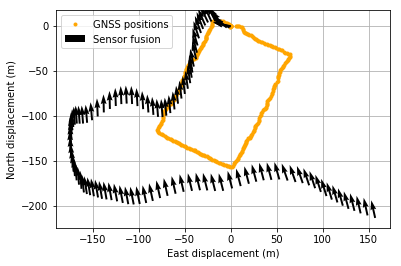

In [79]:
yaw, pitch, roll, rx, ry, rz ,vx, vy, vz = kalman_states.T
yawe, pitche, rolle, rxe, rye, rze, vxe, vye, vze = kalman_errors.T

plt.figure(figsize=(6, 4))
interval = 60
#s = slice(0, int(len(t)/2), interval)
s = slice(0, -1, interval)
dirx = np.cos(yaw[s])
diry = np.sin(yaw[s])

plt.plot(dx, dy ,'.', color='orange', label='GNSS positions')

#plt.plot(rx[::interval], ry[::interval], 'o')
q = plt.quiver(rx[s], ry[s], dirx, diry, label='Sensor fusion', zorder=10)
plt.grid()
plt.legend(loc='best')
#plt.xticks((-80, -60, -40, -20, 0, 20, 40, 60))
#plt.yticks((0, -20, -40, -60, -80, -100, -120, -140, -160))
plt.xlabel('East displacement (m)')
plt.ylabel('North displacement (m)')
plt.savefig('images/walk-around-block-real-Q.png', dpi=300, bbox_inches='tight')